In [1]:
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import queue
from skimage import color
from skimage import io
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [2]:
FEATURES_NUM = 20
GTS_IND_LIST  = [1,3,5,7,11,13,15,17,21,23,26,28,30,32,34,37] 
TEST_IND_LIST = [1,7,15, 32]
TRAIN_IND_LIST = [i for i in GTS_IND_LIST if not i in TEST_IND_LIST]

MAIN_PATH = "/Users/ekaterina/Documents/Semantic Segmentation/ISPRS_semantic_labeling_Vaihingen"
GTS_FORMAT = "/gts_for_participants/top_mosaic_09cm_area{}.tif"
SLIC_RES_FORMAT = "/Output/SLIC/{}_area_{}_segm.txt"

#FEATURES_FORMAT = "/Output/FEATURES_WITH_NEIGHBOURS/{}_area_{}_segm.txt"
FEATURES_FORMAT = "/Output/FEATURES/{}_area_{}_segm.txt"
LABELS_FORMAT = "/Output/LABELS/{}_area_{}_segm.txt"

SEGM_MAX_NUM = 30000 

TREES_NUM = 100
JOBS_NUM = 4

categories = np.zeros((6, 3), dtype = 'uint8')
categories[0]  = [255, 255, 255]
categories[1]  = [0, 0, 255]
categories[2]  = [0, 255, 255]
categories[3]  = [0, 255, 0]
categories[4]  = [255, 255, 0]
categories[5]  = [255, 0, 0]

In [3]:
def show_pic(pic):
    io.imshow(pic)
    io.show()

In [4]:
def get_gts(num):
    label_path = MAIN_PATH + "/gts_for_participants/top_mosaic_09cm_area{}.tif". format(num)
    res = io.imread(label_path)
    return res

In [13]:
def get_slic_res(num, seg_num):
    res_path = MAIN_PATH + SLIC_RES_FORMAT.format(num, seg_num)
    res = np.loadtxt(res_path, dtype = "int")
    return res

In [5]:
def convert_labels_to_color(label_map):
    color_map = np.zeros((label_map.shape[0],label_map.shape[1], 3), dtype = 'uint8')
    for i in range(label_map.shape[0]):
        for j in range (label_map.shape[1]):
            for k in range(6):
                if label_map[i][j] == k:
                    color_map[i][j] = categories[k]
                    break
                    
    return color_map

In [6]:
def convert_color_to_labels(color_map):
    label_map = np.zeros((color_map.shape[0],color_map.shape[1]), dtype = 'uint8')
    for i in range(color_map.shape[0]):
        for j in range (color_map.shape[1]):
            pics = color_map[i][j][:]
            for k in range(6):
                if np.array_equal(pics, categories[k, :]):
                    label_map[i][j] = k
                    break
    return label_map

In [7]:
def make_data_plain(data, features_num):
    plain_data = data.copy()
    plain_data.resize(data.shape[0]*data.shape[1], features_num)
    return plain_data

In [8]:
train_data = np.zeros((0, FEATURES_NUM), dtype = 'float64')
train_labels = np.zeros(0, dtype = 'uint8')
for i in TRAIN_IND_LIST:
    print("Loading area ", i)
    train_data = np.concatenate((train_data, np.loadtxt(MAIN_PATH + FEATURES_FORMAT.format(i,SEGM_MAX_NUM), dtype = 'float64')))
    train_labels = np.concatenate((train_labels, np.loadtxt(MAIN_PATH + LABELS_FORMAT.format(i,SEGM_MAX_NUM), dtype = 'uint8')))

Loading area  3
Loading area  5
Loading area  11
Loading area  13
Loading area  17
Loading area  21
Loading area  23
Loading area  26
Loading area  28
Loading area  30
Loading area  34
Loading area  37


In [9]:
clf = RandomForestClassifier(n_estimators=TREES_NUM, n_jobs = JOBS_NUM)

In [10]:
clf.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

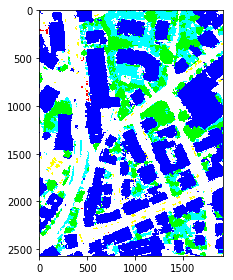

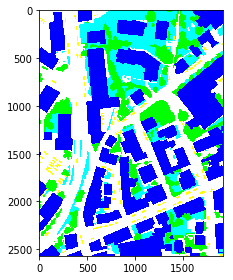

F1 res =  0.913922033526
Acc res =  0.931211131398


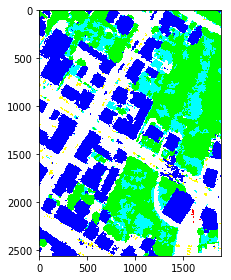

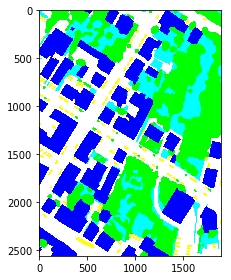

F1 res =  0.911948886009
Acc res =  0.922626645602


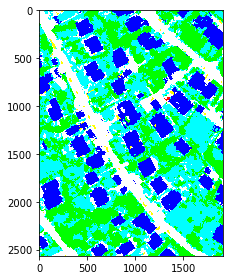

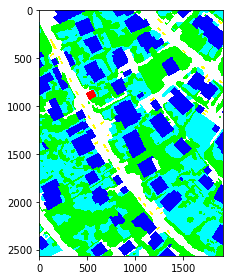

F1 res =  0.892991257584
Acc res =  0.906052027179


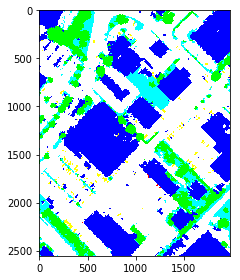

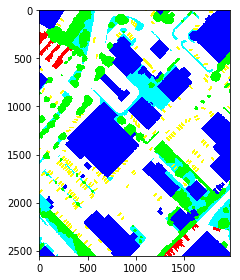

F1 res =  0.896748587849
Acc res =  0.938881772717


In [14]:
for j in TEST_IND_LIST:
    test_data = np.loadtxt(MAIN_PATH + FEATURES_FORMAT.format(j,SEGM_MAX_NUM), dtype = 'float64')
    predicted_plain_labels = clf.predict(test_data)
    mask = get_slic_res(j, SEGM_MAX_NUM)
    for i in range(mask.shape[0]):
        for k in range(mask.shape[1]):
            mask[i][k] = predicted_plain_labels[mask[i][k]]
    test_label_map = get_gts(j)
    predicted_pic = convert_labels_to_color(mask)
    io.imsave(MAIN_PATH + "/Output/RES_RF/Predicted labels for {}_CNN_12_40_features.jpg".format(j), predicted_pic)
    show_pic(predicted_pic)
    show_pic(test_label_map)
    predicted_pic = make_data_plain(predicted_pic,1)
    test_label_map = make_data_plain(test_label_map,1)
    f1_res = f1_score(test_label_map, predicted_pic, labels = [0,1,2,3,4,5], average = 'micro')
    print("F1 res = ",f1_res, )
    acc_res = accuracy_score(test_label_map, predicted_pic )
    print("Acc res = " ,acc_res)